车货相等

In [1]:
import pandas as pd
import numpy as np
import math
from scipy.optimize import linprog
from scipy.optimize import linear_sum_assignment
from math import radians, sin, cos, sqrt, atan2
from pulp import *
import csv
import networkx as nx


# 读取货物和车辆的数据
cargo_df = pd.read_csv('cargo.csv')
vehicles_df = pd.read_csv('vehicles.csv')
type_matching_df = pd.read_csv('Type_matching.csv')


def haversine_distance(point1, point2):
    lat1, lon1 = point1
    lat2, lon2 = point2
    R = 6371  # 地球半径，单位km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2) ** 2
    c0 = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c0
    return distance

# 定义模型参数
w1, w2, w3, w4 = 0.36, 0.11, 0.18, 0.35
n_vehicles = len(vehicles_df)
n_cargo = len(cargo_df)
cargo_types = cargo_df['type'].values
cargo_weights = cargo_df['w_j^c'].values
cargo_volumes = cargo_df['v_j^c'].values
cargo_origins = list(zip(cargo_df['lat_j^c1'].values, cargo_df['lon_j^c1'].values))
cargo_destinations = list(zip(cargo_df['lat_j^c2'].values, cargo_df['lon_j^c2'].values))
cargo_pickup_times = pd.to_datetime(cargo_df['t_j^c1'], format='%Y%m%d%H').values
cargo_delivery_times = pd.to_datetime(cargo_df['t_j^c2'], format='%Y%m%d%H').values
cargo_fees = cargo_df['f_j^c'].values
vehicle_types = vehicles_df['type'].values
vehicle_weights = vehicles_df['w_i^v'].values
vehicle_volumes = vehicles_df['v_i^v'].values
vehicle_latitudes = vehicles_df['lat_i^v'].values
vehicle_longitudes = vehicles_df['lon_i^v'].values
cargo_indexes = np.arange(n_cargo)
vehicle_indexes = np.arange(n_vehicles)

# 计算车辆和货物之间的匹配度a1
matched_pairs = set() # 创建一个空的集合
type_matching = type_matching_df.pivot(index='type_i^v', columns='type_j^c', values='num').fillna(0)
a1 = np.zeros((n_vehicles, n_cargo))
for i in range(n_vehicles):
    for j in range(n_cargo):
        if (i,j) in matched_pairs:
            break # 如果该组匹配已经出现过，则直接跳出内层for循环
        else:
            matching_type = type_matching.loc[vehicles_df['type'][i].split('_')[0], cargo_df['type'][j]]
            matched_pairs.add((i,j)) # 将该组匹配加入已匹配组合的集合中
            a1[i, j] = matching_type
            if matching_type == 0:
                a1[i, j] = 0
                break  # 直接跳出内层for循环

# 计算车辆和货物之间的匹配度a2
a2 = np.zeros((n_vehicles, n_cargo))
for i in range(n_vehicles):
    for j in range(n_cargo):
            # 检查重量和体积是否符合要求
            if cargo_weights[j] <= vehicle_weights[i] and cargo_volumes[j] <= vehicle_volumes[i]:
                a2[i, j] = round(max(1 - ((vehicle_weights[i] - cargo_weights[j]) / vehicle_weights[i]), 1 - ((vehicle_volumes[i] - cargo_volumes[j]) / vehicle_volumes[i])), 2)
                matched_pairs.add((i, j))
            else:
                a2[i, j] = 0

# 计算车辆和货物之间的匹配度a3、a4
a3 = np.zeros((n_vehicles, n_cargo))
a4 = np.zeros((n_vehicles,n_cargo))
z = np.zeros((n_vehicles, n_cargo))
e = np.zeros((n_vehicles,n_cargo))
p = np.zeros((n_vehicles,n_cargo))
c = np.zeros((n_vehicles,n_cargo))
dist1 = np.zeros((n_vehicles,n_cargo))
dist2 = np.zeros((n_vehicles,n_cargo))
time1 = np.zeros((n_vehicles,n_cargo))
time2 = np.zeros((n_vehicles,n_cargo))
total_time = np.zeros((n_vehicles,n_cargo))
delta = np.timedelta64(1, 's')
for i in range(n_vehicles):
    for j in range(n_cargo):
            # 计算距离和时间
            dist1[i, j] = haversine_distance((vehicle_latitudes[i], vehicle_longitudes[i]), cargo_origins[j])
            dist2[i, j] = haversine_distance(cargo_origins[j], cargo_destinations[j])
            time1[i, j] = dist1[i, j] / 40
            time2[i, j] = dist2[i, j] / 80
            total_time[i, j] = time1[i, j] + time2[i, j] + 3
            # 检查时间是否符合要求
         
            time_diff_seconds = (cargo_delivery_times[j] - cargo_pickup_times[j]) / delta
            if total_time[i, j] <= time_diff_seconds / 3600:
                a3[i, j] = round(total_time[i, j] / (time_diff_seconds / (3600 * 2)), 2)
                a4[i, j] = round(dist2[i, j] / (dist1[i, j] + dist2[i, j]), 2)
                matched_pairs.add((i, j))
            else:
                a3[i, j] = 0
                break

b = 1.92
u = 0.5
c[i, j] = u * dist1[i, j] + b * (cargo_weights[j] / vehicle_weights[i]) * u * dist2[i, j]

# 循环检查每个匹配对
for i in range(n_vehicles):
    for j in range(n_cargo):
        # 检查个匹配度是否为零
        if np.any([a1[i, j] == 0, a2[i, j] == 0, a3[i, j] == 0]):
            e[i, j] = z[i, j] = p[i, j] = a4[i, j] = 0
        else:
            a4[i, j] = round(dist2[i, j] / (dist1[i, j] + dist2[i, j]), 2)
            z[i, j] = round((w1 * a1[i, j] + w2 * a2[i, j] + w3 * a3[i, j] + w4 * a4[i, j]), 2)
            e[i, j] = round((cargo_fees[j] - c[i, j]) / (total_time[i, j] + 3), 2)
            p[i, j] = round((cargo_fees[j] - c[i, j]), 2)

z[i, j] = w1 * a1[i, j] + w2 * a2[i, j] + w3 * a3[i, j] + w4 * a4[i, j]
# 输出z矩阵
print("z矩阵:")
print(z)


# 将z矩阵保存在z_matrix全局变量中
z_matrix = z
e_matrix = e
a4_matrix = a4
p_matrix = p
# 定义some_function函数
def some_function():
    global e_matrix
    # 在函数内部对z_matrix做一些处理或者调用其他函数
    # ...

# 在后续代码中调用some_function函数
some_function()


matching_matrix = e_matrix



# 使用Kuhn-Munkres算法求解车辆和货物匹配问题
row_ind, col_ind = linear_sum_assignment(-matching_matrix)
matching = np.column_stack((row_ind, col_ind))

# 输出车辆和货物匹配的结果到csv文件
e_sum = 0
k_sum = 0
p_sum = 0
d_sum = 0
count = 0

with open('MVC_z2_matches.csv', mode='w', encoding='utf-8-sig', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Vehicle', 'Cargo', 'Match', 'PVI', 'EDRI', 'PI', 'PCLDI'])
    
    for vehicle, cargo in matching:
        writer.writerow([vehicle, cargo, 'Yes', e[vehicle][cargo], 1 - a4[vehicle][cargo], p[vehicle][cargo], 1 - a1[vehicle][cargo]])
        
        # 累加"E"和"K"的值
        e_sum += e[vehicle][cargo]
        k_sum += 1 - a4[vehicle][cargo]
        p_sum += p[vehicle][cargo]
        d_sum += 1 - a1[vehicle][cargo]
        count += 1
    
    # 计算"E"和"K"的平均值
    e_mean = e_sum / count
    k_mean = k_sum / count
    p_mean = p_sum / count
    d_mean = d_sum / count
    # 写入"E"和"K"的平均值到CSV文件的对应列的最下方
    writer.writerow(['Average', 'Average', '', e_mean, k_mean, p_mean, d_mean]) 

# 定义some_function函数
def some_function():
    global a4_matrix
    # 在函数内部对z_matrix做一些处理或者调用其他函数
    # ...

# 在后续代码中调用some_function函数
some_function()


matching_matrix = a4_matrix



# 使用Kuhn-Munkres算法求解车辆和货物匹配问题
row_ind, col_ind = linear_sum_assignment(-matching_matrix)
matching = np.column_stack((row_ind, col_ind))

# 输出车辆和货物匹配的结果到csv文件
e_sum = 0
k_sum = 0
p_sum = 0
d_sum = 0
count = 0

with open('MVC_z3_matches.csv', mode='w', encoding='utf-8-sig', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Vehicle', 'Cargo', 'Match', 'PVI', 'EDRI', 'PI', 'PCLDI'])
    
    for vehicle, cargo in matching:
        writer.writerow([vehicle, cargo, 'Yes', e[vehicle][cargo], 1 - a4[vehicle][cargo], p[vehicle][cargo], 1 - a1[vehicle][cargo]])
        
        # 累加"E"和"K"的值
        e_sum += e[vehicle][cargo]
        k_sum += 1 - a4[vehicle][cargo]
        p_sum += p[vehicle][cargo]
        d_sum += 1 - a1[vehicle][cargo]
        count += 1
    
    # 计算"E"和"K"的平均值
    e_mean = e_sum / count
    k_mean = k_sum / count
    p_mean = p_sum / count
    d_mean = d_sum / count
    # 写入"E"和"K"的平均值到CSV文件的对应列的最下方
    writer.writerow(['Average', 'Average', '', e_mean, k_mean, p_mean, d_mean])  

# 定义some_function函数
def some_function():
    global p_matrix
    # 在函数内部对z_matrix做一些处理或者调用其他函数
    # ...

# 在后续代码中调用some_function函数
some_function()


matching_matrix = p_matrix



# 使用Kuhn-Munkres算法求解车辆和货物匹配问题
row_ind, col_ind = linear_sum_assignment(-matching_matrix)
matching = np.column_stack((row_ind, col_ind))

# 输出车辆和货物匹配的结果到csv文件
e_sum = 0
k_sum = 0
p_sum = 0
d_sum = 0
count = 0

with open('MVC_z1_matches.csv', mode='w', encoding='utf-8-sig', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Vehicle', 'Cargo', 'Match', 'PVI', 'EDRI', 'PI', 'PCLDI'])
    
    for vehicle, cargo in matching:
        writer.writerow([vehicle, cargo, 'Yes', e[vehicle][cargo], 1 - a4[vehicle][cargo], p[vehicle][cargo], 1 - a1[vehicle][cargo]])
        
        # 累加"E"和"K"的值
        e_sum += e[vehicle][cargo]
        k_sum += 1 - a4[vehicle][cargo]
        p_sum += p[vehicle][cargo]
        d_sum += 1 - a1[vehicle][cargo]
        count += 1
    
    # 计算"E"和"K"的平均值
    e_mean = e_sum / count
    k_mean = k_sum / count
    p_mean = p_sum / count
    d_mean = d_sum / count
    # 写入"E"和"K"的平均值到CSV文件的对应列的最下方
    writer.writerow(['Average', 'Average', '', e_mean, k_mean, p_mean, d_mean]) 

# 定义some_function函数
def some_function():
    global z_matrix
    # 在函数内部对z_matrix做一些处理或者调用其他函数
    # ...

# 在后续代码中调用some_function函数
some_function()


matching_matrix = z_matrix



# 使用Kuhn-Munkres算法求解车辆和货物匹配问题
row_ind, col_ind = linear_sum_assignment(-matching_matrix)
matching = np.column_stack((row_ind, col_ind))

# 输出车辆和货物匹配的结果到csv文件
e_sum = 0
k_sum = 0
p_sum = 0
d_sum = 0
count = 0

with open('MVC_z4_matches.csv', mode='w', encoding='utf-8-sig', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Vehicle', 'Cargo', 'Match', 'PVI', 'EDRI', 'PI', 'PCLDI'])
    
    for vehicle, cargo in matching:
        writer.writerow([vehicle, cargo, 'Yes', e[vehicle][cargo], 1 - a4[vehicle][cargo], p[vehicle][cargo], 1 - a1[vehicle][cargo]])
        
        # 累加"E"和"K"的值
        e_sum += e[vehicle][cargo]
        k_sum += 1 - a4[vehicle][cargo]
        p_sum += p[vehicle][cargo]
        d_sum += 1 - a1[vehicle][cargo]
        count += 1
    
    # 计算"E"和"K"的平均值
    e_mean = e_sum / count
    k_mean = k_sum / count
    p_mean = p_sum / count
    d_mean = d_sum / count
    # 写入"E"和"K"的平均值到CSV文件的对应列的最下方
    writer.writerow(['Average', 'Average', '', e_mean, k_mean, p_mean, d_mean])  

z矩阵:
[[0.32   0.35   0.31   ... 0.54   0.     0.71  ]
 [0.48   0.5    0.49   ... 0.69   0.45   0.53  ]
 [0.54   0.38   0.37   ... 0.5    0.64   0.56  ]
 ...
 [0.62   0.58   0.55   ... 0.7    0.     0.59  ]
 [0.51   0.41   0.4    ... 0.54   0.51   0.7   ]
 [0.55   0.47   0.45   ... 0.66   0.54   0.5097]]


车多货少

In [2]:
import pandas as pd
import numpy as np
import math
from scipy.optimize import linprog
from scipy.optimize import linear_sum_assignment
from math import radians, sin, cos, sqrt, atan2
from pulp import *
import csv
import networkx as nx


# 读取货物和车辆的数据
cargo_df = pd.read_csv('cargo - s.csv')
vehicles_df = pd.read_csv('vehicles - d.csv')
type_matching_df = pd.read_csv('Type_matching.csv')


def haversine_distance(point1, point2):
    lat1, lon1 = point1
    lat2, lon2 = point2
    R = 6371  # 地球半径，单位km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2) ** 2
    c0 = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c0
    return distance

# 定义模型参数
w1, w2, w3, w4 = 0.36, 0.11, 0.18, 0.35
n_vehicles = len(vehicles_df)
n_cargo = len(cargo_df)
cargo_types = cargo_df['type'].values
cargo_weights = cargo_df['w_j^c'].values
cargo_volumes = cargo_df['v_j^c'].values
cargo_origins = list(zip(cargo_df['lat_j^c1'].values, cargo_df['lon_j^c1'].values))
cargo_destinations = list(zip(cargo_df['lat_j^c2'].values, cargo_df['lon_j^c2'].values))
cargo_pickup_times = pd.to_datetime(cargo_df['t_j^c1'], format='%Y%m%d%H').values
cargo_delivery_times = pd.to_datetime(cargo_df['t_j^c2'], format='%Y%m%d%H').values
cargo_fees = cargo_df['f_j^c'].values
vehicle_types = vehicles_df['type'].values
vehicle_weights = vehicles_df['w_i^v'].values
vehicle_volumes = vehicles_df['v_i^v'].values
vehicle_latitudes = vehicles_df['lat_i^v'].values
vehicle_longitudes = vehicles_df['lon_i^v'].values
cargo_indexes = np.arange(n_cargo)
vehicle_indexes = np.arange(n_vehicles)

# 计算车辆和货物之间的匹配度a1
matched_pairs = set() # 创建一个空的集合
type_matching = type_matching_df.pivot(index='type_i^v', columns='type_j^c', values='num').fillna(0)
a1 = np.zeros((n_vehicles, n_cargo))
for i in range(n_vehicles):
    for j in range(n_cargo):
        if (i,j) in matched_pairs:
            break # 如果该组匹配已经出现过，则直接跳出内层for循环
        else:
            matching_type = type_matching.loc[vehicles_df['type'][i].split('_')[0], cargo_df['type'][j]]
            matched_pairs.add((i,j)) # 将该组匹配加入已匹配组合的集合中
            a1[i, j] = matching_type
            if matching_type == 0:
                a1[i, j] = 0
                break  # 直接跳出内层for循环

# 计算车辆和货物之间的匹配度a2
a2 = np.zeros((n_vehicles, n_cargo))
for i in range(n_vehicles):
    for j in range(n_cargo):
            # 检查重量和体积是否符合要求
            if cargo_weights[j] <= vehicle_weights[i] and cargo_volumes[j] <= vehicle_volumes[i]:
                a2[i, j] = round(max(1 - ((vehicle_weights[i] - cargo_weights[j]) / vehicle_weights[i]), 1 - ((vehicle_volumes[i] - cargo_volumes[j]) / vehicle_volumes[i])), 2)
                matched_pairs.add((i, j))
            else:
                a2[i, j] = 0

# 计算车辆和货物之间的匹配度a3、a4
a3 = np.zeros((n_vehicles, n_cargo))
a4 = np.zeros((n_vehicles,n_cargo))
z = np.zeros((n_vehicles, n_cargo))
e = np.zeros((n_vehicles,n_cargo))
p = np.zeros((n_vehicles,n_cargo))
c = np.zeros((n_vehicles,n_cargo))
dist1 = np.zeros((n_vehicles,n_cargo))
dist2 = np.zeros((n_vehicles,n_cargo))
time1 = np.zeros((n_vehicles,n_cargo))
time2 = np.zeros((n_vehicles,n_cargo))
total_time = np.zeros((n_vehicles,n_cargo))
delta = np.timedelta64(1, 's')
for i in range(n_vehicles):
    for j in range(n_cargo):
            # 计算距离和时间
            dist1[i, j] = haversine_distance((vehicle_latitudes[i], vehicle_longitudes[i]), cargo_origins[j])
            dist2[i, j] = haversine_distance(cargo_origins[j], cargo_destinations[j])
            time1[i, j] = dist1[i, j] / 40
            time2[i, j] = dist2[i, j] / 80
            total_time[i, j] = time1[i, j] + time2[i, j] + 3
            # 检查时间是否符合要求
         
            time_diff_seconds = (cargo_delivery_times[j] - cargo_pickup_times[j]) / delta
            if total_time[i, j] <= time_diff_seconds / 3600:
                a3[i, j] = round(total_time[i, j] / (time_diff_seconds / (3600 * 2)), 2)
                a4[i, j] = round(dist2[i, j] / (dist1[i, j] + dist2[i, j]), 2)
                matched_pairs.add((i, j))
            else:
                a3[i, j] = 0
                break

b = 1.92
u = 0.5
c[i, j] = u * dist1[i, j] + b * (cargo_weights[j] / vehicle_weights[i]) * u * dist2[i, j]

# 循环检查每个匹配对
for i in range(n_vehicles):
    for j in range(n_cargo):
        # 检查个匹配度是否为零
        if np.any([a1[i, j] == 0, a2[i, j] == 0, a3[i, j] == 0]):
            e[i, j] = z[i, j] = p[i, j] = a4[i, j] = 0
        else:
            a4[i, j] = round(dist2[i, j] / (dist1[i, j] + dist2[i, j]), 2)
            z[i, j] = round((w1 * a1[i, j] + w2 * a2[i, j] + w3 * a3[i, j] + w4 * a4[i, j]), 2)
            e[i, j] = round((cargo_fees[j] - c[i, j]) / (total_time[i, j] + 3), 2)
            p[i, j] = round((cargo_fees[j] - c[i, j]), 2)

z[i, j] = w1 * a1[i, j] + w2 * a2[i, j] + w3 * a3[i, j] + w4 * a4[i, j]
# 输出z矩阵
print("z矩阵:")
print(z)


# 将z矩阵保存在z_matrix全局变量中
z_matrix = z
e_matrix = e
a4_matrix = a4
p_matrix = p
# 定义some_function函数
def some_function():
    global e_matrix
    # 在函数内部对z_matrix做一些处理或者调用其他函数
    # ...

# 在后续代码中调用some_function函数
some_function()


matching_matrix = e_matrix



# 使用Kuhn-Munkres算法求解车辆和货物匹配问题
row_ind, col_ind = linear_sum_assignment(-matching_matrix)
matching = np.column_stack((row_ind, col_ind))

# 输出车辆和货物匹配的结果到csv文件
e_sum = 0
k_sum = 0
p_sum = 0
d_sum = 0
count = 0

with open('MVLC_z2_matches.csv', mode='w', encoding='utf-8-sig', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Vehicle', 'Cargo', 'Match', 'PVI', 'EDRI', 'PI', 'PCLDI'])
    
    for vehicle, cargo in matching:
        writer.writerow([vehicle, cargo, 'Yes', e[vehicle][cargo], 1 - a4[vehicle][cargo], p[vehicle][cargo], 1 - a1[vehicle][cargo]])
        
        # 累加"E"和"K"的值
        e_sum += e[vehicle][cargo]
        k_sum += 1 - a4[vehicle][cargo]
        p_sum += p[vehicle][cargo]
        d_sum += 1 - a1[vehicle][cargo]
        count += 1
    
    # 计算"E"和"K"的平均值
    e_mean = e_sum / count
    k_mean = k_sum / count
    p_mean = p_sum / count
    d_mean = d_sum / count
    # 写入"E"和"K"的平均值到CSV文件的对应列的最下方
    writer.writerow(['Average', 'Average', '', e_mean, k_mean, p_mean, d_mean]) 

# 定义some_function函数
def some_function():
    global a4_matrix
    # 在函数内部对z_matrix做一些处理或者调用其他函数
    # ...

# 在后续代码中调用some_function函数
some_function()


matching_matrix = a4_matrix



# 使用Kuhn-Munkres算法求解车辆和货物匹配问题
row_ind, col_ind = linear_sum_assignment(-matching_matrix)
matching = np.column_stack((row_ind, col_ind))

# 输出车辆和货物匹配的结果到csv文件
e_sum = 0
k_sum = 0
p_sum = 0
d_sum = 0
count = 0

with open('MVLC_z3_matches.csv', mode='w', encoding='utf-8-sig', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Vehicle', 'Cargo', 'Match', 'PVI', 'EDRI', 'PI', 'PCLDI'])
    
    for vehicle, cargo in matching:
        writer.writerow([vehicle, cargo, 'Yes', e[vehicle][cargo], 1 - a4[vehicle][cargo], p[vehicle][cargo], 1 - a1[vehicle][cargo]])
        
        # 累加"E"和"K"的值
        e_sum += e[vehicle][cargo]
        k_sum += 1 - a4[vehicle][cargo]
        p_sum += p[vehicle][cargo]
        d_sum += 1 - a1[vehicle][cargo]
        count += 1
    
    # 计算"E"和"K"的平均值
    e_mean = e_sum / count
    k_mean = k_sum / count
    p_mean = p_sum / count
    d_mean = d_sum / count
    # 写入"E"和"K"的平均值到CSV文件的对应列的最下方
    writer.writerow(['Average', 'Average', '', e_mean, k_mean, p_mean, d_mean])  

# 定义some_function函数
def some_function():
    global p_matrix
    # 在函数内部对z_matrix做一些处理或者调用其他函数
    # ...

# 在后续代码中调用some_function函数
some_function()


matching_matrix = p_matrix



# 使用Kuhn-Munkres算法求解车辆和货物匹配问题
row_ind, col_ind = linear_sum_assignment(-matching_matrix)
matching = np.column_stack((row_ind, col_ind))

# 输出车辆和货物匹配的结果到csv文件
e_sum = 0
k_sum = 0
p_sum = 0
d_sum = 0
count = 0

with open('MVLC_z1_matches.csv', mode='w', encoding='utf-8-sig', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Vehicle', 'Cargo', 'Match', 'PVI', 'EDRI', 'PI', 'PCLDI'])
    
    for vehicle, cargo in matching:
        writer.writerow([vehicle, cargo, 'Yes', e[vehicle][cargo], 1 - a4[vehicle][cargo], p[vehicle][cargo], 1 - a1[vehicle][cargo]])
        
        # 累加"E"和"K"的值
        e_sum += e[vehicle][cargo]
        k_sum += 1 - a4[vehicle][cargo]
        p_sum += p[vehicle][cargo]
        d_sum += 1 - a1[vehicle][cargo]
        count += 1
    
    # 计算"E"和"K"的平均值
    e_mean = e_sum / count
    k_mean = k_sum / count
    p_mean = p_sum / count
    d_mean = d_sum / count
    # 写入"E"和"K"的平均值到CSV文件的对应列的最下方
    writer.writerow(['Average', 'Average', '', e_mean, k_mean, p_mean, d_mean]) 

# 定义some_function函数
def some_function():
    global z_matrix
    # 在函数内部对z_matrix做一些处理或者调用其他函数
    # ...

# 在后续代码中调用some_function函数
some_function()


matching_matrix = z_matrix



# 使用Kuhn-Munkres算法求解车辆和货物匹配问题
row_ind, col_ind = linear_sum_assignment(-matching_matrix)
matching = np.column_stack((row_ind, col_ind))

# 输出车辆和货物匹配的结果到csv文件
e_sum = 0
k_sum = 0
p_sum = 0
d_sum = 0
count = 0

with open('MVLC_z4_matches.csv', mode='w', encoding='utf-8-sig', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Vehicle', 'Cargo', 'Match', 'PVI', 'EDRI', 'PI', 'PCLDI'])
    
    for vehicle, cargo in matching:
        writer.writerow([vehicle, cargo, 'Yes', e[vehicle][cargo], 1 - a4[vehicle][cargo], p[vehicle][cargo], 1 - a1[vehicle][cargo]])
        
        # 累加"E"和"K"的值
        e_sum += e[vehicle][cargo]
        k_sum += 1 - a4[vehicle][cargo]
        p_sum += p[vehicle][cargo]
        d_sum += 1 - a1[vehicle][cargo]
        count += 1
    
    # 计算"E"和"K"的平均值
    e_mean = e_sum / count
    k_mean = k_sum / count
    p_mean = p_sum / count
    d_mean = d_sum / count
    # 写入"E"和"K"的平均值到CSV文件的对应列的最下方
    writer.writerow(['Average', 'Average', '', e_mean, k_mean, p_mean, d_mean])  

z矩阵:
[[0.32   0.35   0.31   ... 0.57   0.54   0.    ]
 [0.48   0.5    0.49   ... 0.39   0.69   0.45  ]
 [0.54   0.38   0.37   ... 0.37   0.5    0.64  ]
 ...
 [0.53   0.37   0.36   ... 0.36   0.5    0.8   ]
 [0.51   0.41   0.4    ... 0.53   0.54   0.51  ]
 [0.55   0.39   0.38   ... 0.36   0.58   0.5204]]


车少货多

In [3]:
import pandas as pd
import numpy as np
import math
from scipy.optimize import linprog
from scipy.optimize import linear_sum_assignment
from math import radians, sin, cos, sqrt, atan2
from pulp import *
import csv
import networkx as nx


# 读取货物和车辆的数据
cargo_df = pd.read_csv('cargo - d.csv')
vehicles_df = pd.read_csv('vehicles - s.csv')
type_matching_df = pd.read_csv('Type_matching.csv')


def haversine_distance(point1, point2):
    lat1, lon1 = point1
    lat2, lon2 = point2
    R = 6371  # 地球半径，单位km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2) ** 2
    c0 = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c0
    return distance

# 定义模型参数
w1, w2, w3, w4 = 0.36, 0.11, 0.18, 0.35
n_vehicles = len(vehicles_df)
n_cargo = len(cargo_df)
cargo_types = cargo_df['type'].values
cargo_weights = cargo_df['w_j^c'].values
cargo_volumes = cargo_df['v_j^c'].values
cargo_origins = list(zip(cargo_df['lat_j^c1'].values, cargo_df['lon_j^c1'].values))
cargo_destinations = list(zip(cargo_df['lat_j^c2'].values, cargo_df['lon_j^c2'].values))
cargo_pickup_times = pd.to_datetime(cargo_df['t_j^c1'], format='%Y%m%d%H').values
cargo_delivery_times = pd.to_datetime(cargo_df['t_j^c2'], format='%Y%m%d%H').values
cargo_fees = cargo_df['f_j^c'].values
vehicle_types = vehicles_df['type'].values
vehicle_weights = vehicles_df['w_i^v'].values
vehicle_volumes = vehicles_df['v_i^v'].values
vehicle_latitudes = vehicles_df['lat_i^v'].values
vehicle_longitudes = vehicles_df['lon_i^v'].values
cargo_indexes = np.arange(n_cargo)
vehicle_indexes = np.arange(n_vehicles)

# 计算车辆和货物之间的匹配度a1
matched_pairs = set() # 创建一个空的集合
type_matching = type_matching_df.pivot(index='type_i^v', columns='type_j^c', values='num').fillna(0)
a1 = np.zeros((n_vehicles, n_cargo))
for i in range(n_vehicles):
    for j in range(n_cargo):
        if (i,j) in matched_pairs:
            break # 如果该组匹配已经出现过，则直接跳出内层for循环
        else:
            matching_type = type_matching.loc[vehicles_df['type'][i].split('_')[0], cargo_df['type'][j]]
            matched_pairs.add((i,j)) # 将该组匹配加入已匹配组合的集合中
            a1[i, j] = matching_type
            if matching_type == 0:
                a1[i, j] = 0
                break  # 直接跳出内层for循环

# 计算车辆和货物之间的匹配度a2
a2 = np.zeros((n_vehicles, n_cargo))
for i in range(n_vehicles):
    for j in range(n_cargo):
            # 检查重量和体积是否符合要求
            if cargo_weights[j] <= vehicle_weights[i] and cargo_volumes[j] <= vehicle_volumes[i]:
                a2[i, j] = round(max(1 - ((vehicle_weights[i] - cargo_weights[j]) / vehicle_weights[i]), 1 - ((vehicle_volumes[i] - cargo_volumes[j]) / vehicle_volumes[i])), 2)
                matched_pairs.add((i, j))
            else:
                a2[i, j] = 0

# 计算车辆和货物之间的匹配度a3、a4
a3 = np.zeros((n_vehicles, n_cargo))
a4 = np.zeros((n_vehicles,n_cargo))
z = np.zeros((n_vehicles, n_cargo))
e = np.zeros((n_vehicles,n_cargo))
p = np.zeros((n_vehicles,n_cargo))
c = np.zeros((n_vehicles,n_cargo))
dist1 = np.zeros((n_vehicles,n_cargo))
dist2 = np.zeros((n_vehicles,n_cargo))
time1 = np.zeros((n_vehicles,n_cargo))
time2 = np.zeros((n_vehicles,n_cargo))
total_time = np.zeros((n_vehicles,n_cargo))
delta = np.timedelta64(1, 's')
for i in range(n_vehicles):
    for j in range(n_cargo):
            # 计算距离和时间
            dist1[i, j] = haversine_distance((vehicle_latitudes[i], vehicle_longitudes[i]), cargo_origins[j])
            dist2[i, j] = haversine_distance(cargo_origins[j], cargo_destinations[j])
            time1[i, j] = dist1[i, j] / 40
            time2[i, j] = dist2[i, j] / 80
            total_time[i, j] = time1[i, j] + time2[i, j] + 3
            # 检查时间是否符合要求
         
            time_diff_seconds = (cargo_delivery_times[j] - cargo_pickup_times[j]) / delta
            if total_time[i, j] <= time_diff_seconds / 3600:
                a3[i, j] = round(total_time[i, j] / (time_diff_seconds / (3600 * 2)), 2)
                a4[i, j] = round(dist2[i, j] / (dist1[i, j] + dist2[i, j]), 2)
                matched_pairs.add((i, j))
            else:
                a3[i, j] = 0
                break

b = 1.92
u = 0.5
c[i, j] = u * dist1[i, j] + b * (cargo_weights[j] / vehicle_weights[i]) * u * dist2[i, j]

# 循环检查每个匹配对
for i in range(n_vehicles):
    for j in range(n_cargo):
        # 检查个匹配度是否为零
        if np.any([a1[i, j] == 0, a2[i, j] == 0, a3[i, j] == 0]):
            e[i, j] = z[i, j] = p[i, j] = a4[i, j] = 0
        else:
            a4[i, j] = round(dist2[i, j] / (dist1[i, j] + dist2[i, j]), 2)
            z[i, j] = round((w1 * a1[i, j] + w2 * a2[i, j] + w3 * a3[i, j] + w4 * a4[i, j]), 2)
            e[i, j] = round((cargo_fees[j] - c[i, j]) / (total_time[i, j] + 3), 2)
            p[i, j] = round((cargo_fees[j] - c[i, j]), 2)

z[i, j] = w1 * a1[i, j] + w2 * a2[i, j] + w3 * a3[i, j] + w4 * a4[i, j]
# 输出z矩阵
print("z矩阵:")
print(z)


# 将z矩阵保存在z_matrix全局变量中
z_matrix = z
e_matrix = e
a4_matrix = a4
p_matrix = p
# 定义some_function函数
def some_function():
    global e_matrix
    # 在函数内部对z_matrix做一些处理或者调用其他函数
    # ...

# 在后续代码中调用some_function函数
some_function()


matching_matrix = e_matrix



# 使用Kuhn-Munkres算法求解车辆和货物匹配问题
row_ind, col_ind = linear_sum_assignment(-matching_matrix)
matching = np.column_stack((row_ind, col_ind))

# 输出车辆和货物匹配的结果到csv文件
e_sum = 0
k_sum = 0
p_sum = 0
d_sum = 0
count = 0

with open('FVMC_z2_matches.csv', mode='w', encoding='utf-8-sig', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Vehicle', 'Cargo', 'Match', 'PVI', 'EDRI', 'PI', 'PCLDI'])
    
    for vehicle, cargo in matching:
        writer.writerow([vehicle, cargo, 'Yes', e[vehicle][cargo], 1 - a4[vehicle][cargo], p[vehicle][cargo], 1 - a1[vehicle][cargo]])
        
        # 累加"E"和"K"的值
        e_sum += e[vehicle][cargo]
        k_sum += 1 - a4[vehicle][cargo]
        p_sum += p[vehicle][cargo]
        d_sum += 1 - a1[vehicle][cargo]
        count += 1
    
    # 计算"E"和"K"的平均值
    e_mean = e_sum / count
    k_mean = k_sum / count
    p_mean = p_sum / count
    d_mean = d_sum / count
    # 写入"E"和"K"的平均值到CSV文件的对应列的最下方
    writer.writerow(['Average', 'Average', '', e_mean, k_mean, p_mean, d_mean]) 

# 定义some_function函数
def some_function():
    global a4_matrix
    # 在函数内部对z_matrix做一些处理或者调用其他函数
    # ...

# 在后续代码中调用some_function函数
some_function()


matching_matrix = a4_matrix



# 使用Kuhn-Munkres算法求解车辆和货物匹配问题
row_ind, col_ind = linear_sum_assignment(-matching_matrix)
matching = np.column_stack((row_ind, col_ind))

# 输出车辆和货物匹配的结果到csv文件
e_sum = 0
k_sum = 0
p_sum = 0
d_sum = 0
count = 0

with open('FVMC_z3_matches.csv', mode='w', encoding='utf-8-sig', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Vehicle', 'Cargo', 'Match', 'PVI', 'EDRI', 'PI', 'PCLDI'])
    
    for vehicle, cargo in matching:
        writer.writerow([vehicle, cargo, 'Yes', e[vehicle][cargo], 1 - a4[vehicle][cargo], p[vehicle][cargo], 1 - a1[vehicle][cargo]])
        
        # 累加"E"和"K"的值
        e_sum += e[vehicle][cargo]
        k_sum += 1 - a4[vehicle][cargo]
        p_sum += p[vehicle][cargo]
        d_sum += 1 - a1[vehicle][cargo]
        count += 1
    
    # 计算"E"和"K"的平均值
    e_mean = e_sum / count
    k_mean = k_sum / count
    p_mean = p_sum / count
    d_mean = d_sum / count
    # 写入"E"和"K"的平均值到CSV文件的对应列的最下方
    writer.writerow(['Average', 'Average', '', e_mean, k_mean, p_mean, d_mean])  

# 定义some_function函数
def some_function():
    global p_matrix
    # 在函数内部对z_matrix做一些处理或者调用其他函数
    # ...

# 在后续代码中调用some_function函数
some_function()


matching_matrix = p_matrix



# 使用Kuhn-Munkres算法求解车辆和货物匹配问题
row_ind, col_ind = linear_sum_assignment(-matching_matrix)
matching = np.column_stack((row_ind, col_ind))

# 输出车辆和货物匹配的结果到csv文件
e_sum = 0
k_sum = 0
p_sum = 0
d_sum = 0
count = 0

with open('FVMC_z1_matches.csv', mode='w', encoding='utf-8-sig', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Vehicle', 'Cargo', 'Match', 'PVI', 'EDRI', 'PI', 'PCLDI'])
    
    for vehicle, cargo in matching:
        writer.writerow([vehicle, cargo, 'Yes', e[vehicle][cargo], 1 - a4[vehicle][cargo], p[vehicle][cargo], 1 - a1[vehicle][cargo]])
        
        # 累加"E"和"K"的值
        e_sum += e[vehicle][cargo]
        k_sum += 1 - a4[vehicle][cargo]
        p_sum += p[vehicle][cargo]
        d_sum += 1 - a1[vehicle][cargo]
        count += 1
    
    # 计算"E"和"K"的平均值
    e_mean = e_sum / count
    k_mean = k_sum / count
    p_mean = p_sum / count
    d_mean = d_sum / count
    # 写入"E"和"K"的平均值到CSV文件的对应列的最下方
    writer.writerow(['Average', 'Average', '', e_mean, k_mean, p_mean, d_mean]) 

# 定义some_function函数
def some_function():
    global z_matrix
    # 在函数内部对z_matrix做一些处理或者调用其他函数
    # ...

# 在后续代码中调用some_function函数
some_function()


matching_matrix = z_matrix



# 使用Kuhn-Munkres算法求解车辆和货物匹配问题
row_ind, col_ind = linear_sum_assignment(-matching_matrix)
matching = np.column_stack((row_ind, col_ind))

# 输出车辆和货物匹配的结果到csv文件
e_sum = 0
k_sum = 0
p_sum = 0
d_sum = 0
count = 0

with open('FVMC_z4_matches.csv', mode='w', encoding='utf-8-sig', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Vehicle', 'Cargo', 'Match', 'PVI', 'EDRI', 'PI', 'PCLDI'])
    
    for vehicle, cargo in matching:
        writer.writerow([vehicle, cargo, 'Yes', e[vehicle][cargo], 1 - a4[vehicle][cargo], p[vehicle][cargo], 1 - a1[vehicle][cargo]])
        
        # 累加"E"和"K"的值
        e_sum += e[vehicle][cargo]
        k_sum += 1 - a4[vehicle][cargo]
        p_sum += p[vehicle][cargo]
        d_sum += 1 - a1[vehicle][cargo]
        count += 1
    
    # 计算"E"和"K"的平均值
    e_mean = e_sum / count
    k_mean = k_sum / count
    p_mean = p_sum / count
    d_mean = d_sum / count
    # 写入"E"和"K"的平均值到CSV文件的对应列的最下方
    writer.writerow(['Average', 'Average', '', e_mean, k_mean, p_mean, d_mean])  

z矩阵:
[[0.32   0.35   0.31   ... 0.73   0.31   0.    ]
 [0.48   0.5    0.49   ... 0.55   0.53   0.76  ]
 [0.54   0.38   0.37   ... 0.55   0.     0.    ]
 ...
 [0.36   0.36   0.36   ... 0.72   0.29   0.    ]
 [0.62   0.58   0.55   ... 0.57   0.8    0.    ]
 [0.51   0.41   0.4    ... 0.73   0.62   0.4487]]


车少货少

In [4]:
import pandas as pd
import numpy as np
import math
from scipy.optimize import linprog
from scipy.optimize import linear_sum_assignment
from math import radians, sin, cos, sqrt, atan2
from pulp import *
import csv
import networkx as nx


# 读取货物和车辆的数据
cargo_df = pd.read_csv('cargo - ss.csv')
vehicles_df = pd.read_csv('vehicles - ss.csv')
type_matching_df = pd.read_csv('Type_matching.csv')


def haversine_distance(point1, point2):
    lat1, lon1 = point1
    lat2, lon2 = point2
    R = 6371  # 地球半径，单位km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2) ** 2
    c0 = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c0
    return distance

# 定义模型参数
w1, w2, w3, w4 = 0.36, 0.11, 0.18, 0.35
n_vehicles = len(vehicles_df)
n_cargo = len(cargo_df)
cargo_types = cargo_df['type'].values
cargo_weights = cargo_df['w_j^c'].values
cargo_volumes = cargo_df['v_j^c'].values
cargo_origins = list(zip(cargo_df['lat_j^c1'].values, cargo_df['lon_j^c1'].values))
cargo_destinations = list(zip(cargo_df['lat_j^c2'].values, cargo_df['lon_j^c2'].values))
cargo_pickup_times = pd.to_datetime(cargo_df['t_j^c1'], format='%Y%m%d%H').values
cargo_delivery_times = pd.to_datetime(cargo_df['t_j^c2'], format='%Y%m%d%H').values
cargo_fees = cargo_df['f_j^c'].values
vehicle_types = vehicles_df['type'].values
vehicle_weights = vehicles_df['w_i^v'].values
vehicle_volumes = vehicles_df['v_i^v'].values
vehicle_latitudes = vehicles_df['lat_i^v'].values
vehicle_longitudes = vehicles_df['lon_i^v'].values
cargo_indexes = np.arange(n_cargo)
vehicle_indexes = np.arange(n_vehicles)

# 计算车辆和货物之间的匹配度a1
matched_pairs = set() # 创建一个空的集合
type_matching = type_matching_df.pivot(index='type_i^v', columns='type_j^c', values='num').fillna(0)
a1 = np.zeros((n_vehicles, n_cargo))
for i in range(n_vehicles):
    for j in range(n_cargo):
        if (i,j) in matched_pairs:
            break # 如果该组匹配已经出现过，则直接跳出内层for循环
        else:
            matching_type = type_matching.loc[vehicles_df['type'][i].split('_')[0], cargo_df['type'][j]]
            matched_pairs.add((i,j)) # 将该组匹配加入已匹配组合的集合中
            a1[i, j] = matching_type
            if matching_type == 0:
                a1[i, j] = 0
                break  # 直接跳出内层for循环

# 计算车辆和货物之间的匹配度a2
a2 = np.zeros((n_vehicles, n_cargo))
for i in range(n_vehicles):
    for j in range(n_cargo):
            # 检查重量和体积是否符合要求
            if cargo_weights[j] <= vehicle_weights[i] and cargo_volumes[j] <= vehicle_volumes[i]:
                a2[i, j] = round(max(1 - ((vehicle_weights[i] - cargo_weights[j]) / vehicle_weights[i]), 1 - ((vehicle_volumes[i] - cargo_volumes[j]) / vehicle_volumes[i])), 2)
                matched_pairs.add((i, j))
            else:
                a2[i, j] = 0

# 计算车辆和货物之间的匹配度a3、a4
a3 = np.zeros((n_vehicles, n_cargo))
a4 = np.zeros((n_vehicles,n_cargo))
z = np.zeros((n_vehicles, n_cargo))
e = np.zeros((n_vehicles,n_cargo))
p = np.zeros((n_vehicles,n_cargo))
c = np.zeros((n_vehicles,n_cargo))
dist1 = np.zeros((n_vehicles,n_cargo))
dist2 = np.zeros((n_vehicles,n_cargo))
time1 = np.zeros((n_vehicles,n_cargo))
time2 = np.zeros((n_vehicles,n_cargo))
total_time = np.zeros((n_vehicles,n_cargo))
delta = np.timedelta64(1, 's')
for i in range(n_vehicles):
    for j in range(n_cargo):
            # 计算距离和时间
            dist1[i, j] = haversine_distance((vehicle_latitudes[i], vehicle_longitudes[i]), cargo_origins[j])
            dist2[i, j] = haversine_distance(cargo_origins[j], cargo_destinations[j])
            time1[i, j] = dist1[i, j] / 40
            time2[i, j] = dist2[i, j] / 80
            total_time[i, j] = time1[i, j] + time2[i, j] + 3
            # 检查时间是否符合要求
         
            time_diff_seconds = (cargo_delivery_times[j] - cargo_pickup_times[j]) / delta
            if total_time[i, j] <= time_diff_seconds / 3600:
                a3[i, j] = round(total_time[i, j] / (time_diff_seconds / (3600 * 2)), 2)
                a4[i, j] = round(dist2[i, j] / (dist1[i, j] + dist2[i, j]), 2)
                matched_pairs.add((i, j))
            else:
                a3[i, j] = 0
                break

b = 1.92
u = 0.5
c[i, j] = u * dist1[i, j] + b * (cargo_weights[j] / vehicle_weights[i]) * u * dist2[i, j]

# 循环检查每个匹配对
for i in range(n_vehicles):
    for j in range(n_cargo):
        # 检查个匹配度是否为零
        if np.any([a1[i, j] == 0, a2[i, j] == 0, a3[i, j] == 0]):
            e[i, j] = z[i, j] = p[i, j] = a4[i, j] = 0
        else:
            a4[i, j] = round(dist2[i, j] / (dist1[i, j] + dist2[i, j]), 2)
            z[i, j] = round((w1 * a1[i, j] + w2 * a2[i, j] + w3 * a3[i, j] + w4 * a4[i, j]), 2)
            e[i, j] = round((cargo_fees[j] - c[i, j]) / (total_time[i, j] + 3), 2)
            p[i, j] = round((cargo_fees[j] - c[i, j]), 2)

z[i, j] = w1 * a1[i, j] + w2 * a2[i, j] + w3 * a3[i, j] + w4 * a4[i, j]
# 输出z矩阵
print("z矩阵:")
print(z)


# 将z矩阵保存在z_matrix全局变量中
z_matrix = z
e_matrix = e
a4_matrix = a4
p_matrix = p
# 定义some_function函数
def some_function():
    global e_matrix
    # 在函数内部对z_matrix做一些处理或者调用其他函数
    # ...

# 在后续代码中调用some_function函数
some_function()


matching_matrix = e_matrix



# 使用Kuhn-Munkres算法求解车辆和货物匹配问题
row_ind, col_ind = linear_sum_assignment(-matching_matrix)
matching = np.column_stack((row_ind, col_ind))

# 输出车辆和货物匹配的结果到csv文件
e_sum = 0
k_sum = 0
p_sum = 0
d_sum = 0
count = 0

with open('FVLC_z2_matches.csv', mode='w', encoding='utf-8-sig', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Vehicle', 'Cargo', 'Match', 'PVI', 'EDRI', 'PI', 'PCLDI'])
    
    for vehicle, cargo in matching:
        writer.writerow([vehicle, cargo, 'Yes', e[vehicle][cargo], 1 - a4[vehicle][cargo], p[vehicle][cargo], 1 - a1[vehicle][cargo]])
        
        # 累加"E"和"K"的值
        e_sum += e[vehicle][cargo]
        k_sum += 1 - a4[vehicle][cargo]
        p_sum += p[vehicle][cargo]
        d_sum += 1 - a1[vehicle][cargo]
        count += 1
    
    # 计算"E"和"K"的平均值
    e_mean = e_sum / count
    k_mean = k_sum / count
    p_mean = p_sum / count
    d_mean = d_sum / count
    # 写入"E"和"K"的平均值到CSV文件的对应列的最下方
    writer.writerow(['Average', 'Average', '', e_mean, k_mean, p_mean, d_mean]) 

# 定义some_function函数
def some_function():
    global a4_matrix
    # 在函数内部对z_matrix做一些处理或者调用其他函数
    # ...

# 在后续代码中调用some_function函数
some_function()


matching_matrix = a4_matrix



# 使用Kuhn-Munkres算法求解车辆和货物匹配问题
row_ind, col_ind = linear_sum_assignment(-matching_matrix)
matching = np.column_stack((row_ind, col_ind))

# 输出车辆和货物匹配的结果到csv文件
e_sum = 0
k_sum = 0
p_sum = 0
d_sum = 0
count = 0

with open('FVLC_z3_matches.csv', mode='w', encoding='utf-8-sig', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Vehicle', 'Cargo', 'Match', 'PVI', 'EDRI', 'PI', 'PCLDI'])
    
    for vehicle, cargo in matching:
        writer.writerow([vehicle, cargo, 'Yes', e[vehicle][cargo], 1 - a4[vehicle][cargo], p[vehicle][cargo], 1 - a1[vehicle][cargo]])
        
        # 累加"E"和"K"的值
        e_sum += e[vehicle][cargo]
        k_sum += 1 - a4[vehicle][cargo]
        p_sum += p[vehicle][cargo]
        d_sum += 1 - a1[vehicle][cargo]
        count += 1
    
    # 计算"E"和"K"的平均值
    e_mean = e_sum / count
    k_mean = k_sum / count
    p_mean = p_sum / count
    d_mean = d_sum / count
    # 写入"E"和"K"的平均值到CSV文件的对应列的最下方
    writer.writerow(['Average', 'Average', '', e_mean, k_mean, p_mean, d_mean])  

# 定义some_function函数
def some_function():
    global p_matrix
    # 在函数内部对z_matrix做一些处理或者调用其他函数
    # ...

# 在后续代码中调用some_function函数
some_function()


matching_matrix = p_matrix



# 使用Kuhn-Munkres算法求解车辆和货物匹配问题
row_ind, col_ind = linear_sum_assignment(-matching_matrix)
matching = np.column_stack((row_ind, col_ind))

# 输出车辆和货物匹配的结果到csv文件
e_sum = 0
k_sum = 0
p_sum = 0
d_sum = 0
count = 0

with open('FVLC_z1_matches.csv', mode='w', encoding='utf-8-sig', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Vehicle', 'Cargo', 'Match', 'PVI', 'EDRI', 'PI', 'PCLDI'])
    
    for vehicle, cargo in matching:
        writer.writerow([vehicle, cargo, 'Yes', e[vehicle][cargo], 1 - a4[vehicle][cargo], p[vehicle][cargo], 1 - a1[vehicle][cargo]])
        
        # 累加"E"和"K"的值
        e_sum += e[vehicle][cargo]
        k_sum += 1 - a4[vehicle][cargo]
        p_sum += p[vehicle][cargo]
        d_sum += 1 - a1[vehicle][cargo]
        count += 1
    
    # 计算"E"和"K"的平均值
    e_mean = e_sum / count
    k_mean = k_sum / count
    p_mean = p_sum / count
    d_mean = d_sum / count
    # 写入"E"和"K"的平均值到CSV文件的对应列的最下方
    writer.writerow(['Average', 'Average', '', e_mean, k_mean, p_mean, d_mean]) 

# 定义some_function函数
def some_function():
    global z_matrix
    # 在函数内部对z_matrix做一些处理或者调用其他函数
    # ...

# 在后续代码中调用some_function函数
some_function()


matching_matrix = z_matrix



# 使用Kuhn-Munkres算法求解车辆和货物匹配问题
row_ind, col_ind = linear_sum_assignment(-matching_matrix)
matching = np.column_stack((row_ind, col_ind))

# 输出车辆和货物匹配的结果到csv文件
e_sum = 0
k_sum = 0
p_sum = 0
d_sum = 0
count = 0

with open('FVLC_z4_matches.csv', mode='w', encoding='utf-8-sig', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Vehicle', 'Cargo', 'Match', 'PVI', 'EDRI', 'PI', 'PCLDI'])
    
    for vehicle, cargo in matching:
        writer.writerow([vehicle, cargo, 'Yes', e[vehicle][cargo], 1 - a4[vehicle][cargo], p[vehicle][cargo], 1 - a1[vehicle][cargo]])
        
        # 累加"E"和"K"的值
        e_sum += e[vehicle][cargo]
        k_sum += 1 - a4[vehicle][cargo]
        p_sum += p[vehicle][cargo]
        d_sum += 1 - a1[vehicle][cargo]
        count += 1
    
    # 计算"E"和"K"的平均值
    e_mean = e_sum / count
    k_mean = k_sum / count
    p_mean = p_sum / count
    d_mean = d_sum / count
    # 写入"E"和"K"的平均值到CSV文件的对应列的最下方
    writer.writerow(['Average', 'Average', '', e_mean, k_mean, p_mean, d_mean])  

z矩阵:
[[0.32   0.35   0.31   0.     0.31   0.     0.82   0.     0.     0.39
  0.31   0.73   0.     0.59   0.54   0.     0.69   0.     0.34   0.    ]
 [0.48   0.5    0.49   0.     0.52   0.76   0.64   0.65   0.6    0.58
  0.47   0.55   0.58   0.41   0.69   0.49   0.51   0.46   0.52   0.54  ]
 [0.54   0.38   0.37   0.     0.     0.     0.32   0.     0.66   0.69
  0.5    0.55   0.     0.51   0.5    0.57   0.55   0.     0.64   0.    ]
 [0.53   0.45   0.42   0.53   0.53   0.     0.34   0.     0.67   0.66
  0.63   0.56   0.     0.5    0.57   0.58   0.55   0.     0.62   0.    ]
 [0.52   0.42   0.41   0.5    0.53   0.45   0.5    0.43   0.57   0.64
  0.54   0.72   0.68   0.68   0.54   0.48   0.72   0.57   0.59   0.61  ]
 [0.53   0.45   0.42   0.53   0.53   0.     0.34   0.     0.67   0.66
  0.63   0.56   0.     0.5    0.57   0.58   0.55   0.     0.62   0.    ]
 [0.63   0.     0.56   0.     0.63   0.     0.     0.     0.     0.77
  0.     0.     0.     0.     0.     0.     0.     0.     0.72   0.

车多货多

In [5]:
import pandas as pd
import numpy as np
import math
from scipy.optimize import linprog
from scipy.optimize import linear_sum_assignment
from math import radians, sin, cos, sqrt, atan2
from pulp import *
import csv
import networkx as nx


# 读取货物和车辆的数据
cargo_df = pd.read_csv('cargo - dd.csv')
vehicles_df = pd.read_csv('vehicles - dd.csv')
type_matching_df = pd.read_csv('Type_matching.csv')


def haversine_distance(point1, point2):
    lat1, lon1 = point1
    lat2, lon2 = point2
    R = 6371  # 地球半径，单位km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2) ** 2
    c0 = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c0
    return distance

# 定义模型参数
w1, w2, w3, w4 = 0.36, 0.11, 0.18, 0.35
n_vehicles = len(vehicles_df)
n_cargo = len(cargo_df)
cargo_types = cargo_df['type'].values
cargo_weights = cargo_df['w_j^c'].values
cargo_volumes = cargo_df['v_j^c'].values
cargo_origins = list(zip(cargo_df['lat_j^c1'].values, cargo_df['lon_j^c1'].values))
cargo_destinations = list(zip(cargo_df['lat_j^c2'].values, cargo_df['lon_j^c2'].values))
cargo_pickup_times = pd.to_datetime(cargo_df['t_j^c1'], format='%Y%m%d%H').values
cargo_delivery_times = pd.to_datetime(cargo_df['t_j^c2'], format='%Y%m%d%H').values
cargo_fees = cargo_df['f_j^c'].values
vehicle_types = vehicles_df['type'].values
vehicle_weights = vehicles_df['w_i^v'].values
vehicle_volumes = vehicles_df['v_i^v'].values
vehicle_latitudes = vehicles_df['lat_i^v'].values
vehicle_longitudes = vehicles_df['lon_i^v'].values
cargo_indexes = np.arange(n_cargo)
vehicle_indexes = np.arange(n_vehicles)

# 计算车辆和货物之间的匹配度a1
matched_pairs = set() # 创建一个空的集合
type_matching = type_matching_df.pivot(index='type_i^v', columns='type_j^c', values='num').fillna(0)
a1 = np.zeros((n_vehicles, n_cargo))
for i in range(n_vehicles):
    for j in range(n_cargo):
        if (i,j) in matched_pairs:
            break # 如果该组匹配已经出现过，则直接跳出内层for循环
        else:
            matching_type = type_matching.loc[vehicles_df['type'][i].split('_')[0], cargo_df['type'][j]]
            matched_pairs.add((i,j)) # 将该组匹配加入已匹配组合的集合中
            a1[i, j] = matching_type
            if matching_type == 0:
                a1[i, j] = 0
                break  # 直接跳出内层for循环

# 计算车辆和货物之间的匹配度a2
a2 = np.zeros((n_vehicles, n_cargo))
for i in range(n_vehicles):
    for j in range(n_cargo):
            # 检查重量和体积是否符合要求
            if cargo_weights[j] <= vehicle_weights[i] and cargo_volumes[j] <= vehicle_volumes[i]:
                a2[i, j] = round(max(1 - ((vehicle_weights[i] - cargo_weights[j]) / vehicle_weights[i]), 1 - ((vehicle_volumes[i] - cargo_volumes[j]) / vehicle_volumes[i])), 2)
                matched_pairs.add((i, j))
            else:
                a2[i, j] = 0

# 计算车辆和货物之间的匹配度a3、a4
a3 = np.zeros((n_vehicles, n_cargo))
a4 = np.zeros((n_vehicles,n_cargo))
z = np.zeros((n_vehicles, n_cargo))
e = np.zeros((n_vehicles,n_cargo))
p = np.zeros((n_vehicles,n_cargo))
c = np.zeros((n_vehicles,n_cargo))
dist1 = np.zeros((n_vehicles,n_cargo))
dist2 = np.zeros((n_vehicles,n_cargo))
time1 = np.zeros((n_vehicles,n_cargo))
time2 = np.zeros((n_vehicles,n_cargo))
total_time = np.zeros((n_vehicles,n_cargo))
delta = np.timedelta64(1, 's')
for i in range(n_vehicles):
    for j in range(n_cargo):
            # 计算距离和时间
            dist1[i, j] = haversine_distance((vehicle_latitudes[i], vehicle_longitudes[i]), cargo_origins[j])
            dist2[i, j] = haversine_distance(cargo_origins[j], cargo_destinations[j])
            time1[i, j] = dist1[i, j] / 40
            time2[i, j] = dist2[i, j] / 80
            total_time[i, j] = time1[i, j] + time2[i, j] + 3
            # 检查时间是否符合要求
         
            time_diff_seconds = (cargo_delivery_times[j] - cargo_pickup_times[j]) / delta
            if total_time[i, j] <= time_diff_seconds / 3600:
                a3[i, j] = round(total_time[i, j] / (time_diff_seconds / (3600 * 2)), 2)
                a4[i, j] = round(dist2[i, j] / (dist1[i, j] + dist2[i, j]), 2)
                matched_pairs.add((i, j))
            else:
                a3[i, j] = 0
                break

b = 1.92
u = 0.5
c[i, j] = u * dist1[i, j] + b * (cargo_weights[j] / vehicle_weights[i]) * u * dist2[i, j]

# 循环检查每个匹配对
for i in range(n_vehicles):
    for j in range(n_cargo):
        # 检查个匹配度是否为零
        if np.any([a1[i, j] == 0, a2[i, j] == 0, a3[i, j] == 0]):
            e[i, j] = z[i, j] = p[i, j] = a4[i, j] = 0
        else:
            a4[i, j] = round(dist2[i, j] / (dist1[i, j] + dist2[i, j]), 2)
            z[i, j] = round((w1 * a1[i, j] + w2 * a2[i, j] + w3 * a3[i, j] + w4 * a4[i, j]), 2)
            e[i, j] = round((cargo_fees[j] - c[i, j]) / (total_time[i, j] + 3), 2)
            p[i, j] = round((cargo_fees[j] - c[i, j]), 2)

z[i, j] = w1 * a1[i, j] + w2 * a2[i, j] + w3 * a3[i, j] + w4 * a4[i, j]
# 输出z矩阵
print("z矩阵:")
print(z)


# 将z矩阵保存在z_matrix全局变量中
z_matrix = z
e_matrix = e
a4_matrix = a4
p_matrix = p
# 定义some_function函数
def some_function():
    global e_matrix
    # 在函数内部对z_matrix做一些处理或者调用其他函数
    # ...

# 在后续代码中调用some_function函数
some_function()


matching_matrix = e_matrix



# 使用Kuhn-Munkres算法求解车辆和货物匹配问题
row_ind, col_ind = linear_sum_assignment(-matching_matrix)
matching = np.column_stack((row_ind, col_ind))

# 输出车辆和货物匹配的结果到csv文件
e_sum = 0
k_sum = 0
p_sum = 0
d_sum = 0
count = 0

with open('MVMC_z2_matches.csv', mode='w', encoding='utf-8-sig', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Vehicle', 'Cargo', 'Match', 'PVI', 'EDRI', 'PI', 'PCLDI'])
    
    for vehicle, cargo in matching:
        writer.writerow([vehicle, cargo, 'Yes', e[vehicle][cargo], 1 - a4[vehicle][cargo], p[vehicle][cargo], 1 - a1[vehicle][cargo]])
        
        # 累加"E"和"K"的值
        e_sum += e[vehicle][cargo]
        k_sum += 1 - a4[vehicle][cargo]
        p_sum += p[vehicle][cargo]
        d_sum += 1 - a1[vehicle][cargo]
        count += 1
    
    # 计算"E"和"K"的平均值
    e_mean = e_sum / count
    k_mean = k_sum / count
    p_mean = p_sum / count
    d_mean = d_sum / count
    # 写入"E"和"K"的平均值到CSV文件的对应列的最下方
    writer.writerow(['Average', 'Average', '', e_mean, k_mean, p_mean, d_mean]) 

# 定义some_function函数
def some_function():
    global a4_matrix
    # 在函数内部对z_matrix做一些处理或者调用其他函数
    # ...

# 在后续代码中调用some_function函数
some_function()


matching_matrix = a4_matrix



# 使用Kuhn-Munkres算法求解车辆和货物匹配问题
row_ind, col_ind = linear_sum_assignment(-matching_matrix)
matching = np.column_stack((row_ind, col_ind))

# 输出车辆和货物匹配的结果到csv文件
e_sum = 0
k_sum = 0
p_sum = 0
d_sum = 0
count = 0

with open('MVMC_z3_matches.csv', mode='w', encoding='utf-8-sig', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Vehicle', 'Cargo', 'Match', 'PVI', 'EDRI', 'PI', 'PCLDI'])
    
    for vehicle, cargo in matching:
        writer.writerow([vehicle, cargo, 'Yes', e[vehicle][cargo], 1 - a4[vehicle][cargo], p[vehicle][cargo], 1 - a1[vehicle][cargo]])
        
        # 累加"E"和"K"的值
        e_sum += e[vehicle][cargo]
        k_sum += 1 - a4[vehicle][cargo]
        p_sum += p[vehicle][cargo]
        d_sum += 1 - a1[vehicle][cargo]
        count += 1
    
    # 计算"E"和"K"的平均值
    e_mean = e_sum / count
    k_mean = k_sum / count
    p_mean = p_sum / count
    d_mean = d_sum / count
    # 写入"E"和"K"的平均值到CSV文件的对应列的最下方
    writer.writerow(['Average', 'Average', '', e_mean, k_mean, p_mean, d_mean])  

# 定义some_function函数
def some_function():
    global p_matrix
    # 在函数内部对z_matrix做一些处理或者调用其他函数
    # ...

# 在后续代码中调用some_function函数
some_function()


matching_matrix = p_matrix



# 使用Kuhn-Munkres算法求解车辆和货物匹配问题
row_ind, col_ind = linear_sum_assignment(-matching_matrix)
matching = np.column_stack((row_ind, col_ind))

# 输出车辆和货物匹配的结果到csv文件
e_sum = 0
k_sum = 0
p_sum = 0
d_sum = 0
count = 0

with open('MVMC_z1_matches.csv', mode='w', encoding='utf-8-sig', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Vehicle', 'Cargo', 'Match', 'PVI', 'EDRI', 'PI', 'PCLDI'])
    
    for vehicle, cargo in matching:
        writer.writerow([vehicle, cargo, 'Yes', e[vehicle][cargo], 1 - a4[vehicle][cargo], p[vehicle][cargo], 1 - a1[vehicle][cargo]])
        
        # 累加"E"和"K"的值
        e_sum += e[vehicle][cargo]
        k_sum += 1 - a4[vehicle][cargo]
        p_sum += p[vehicle][cargo]
        d_sum += 1 - a1[vehicle][cargo]
        count += 1
    
    # 计算"E"和"K"的平均值
    e_mean = e_sum / count
    k_mean = k_sum / count
    p_mean = p_sum / count
    d_mean = d_sum / count
    # 写入"E"和"K"的平均值到CSV文件的对应列的最下方
    writer.writerow(['Average', 'Average', '', e_mean, k_mean, p_mean, d_mean]) 

# 定义some_function函数
def some_function():
    global z_matrix
    # 在函数内部对z_matrix做一些处理或者调用其他函数
    # ...

# 在后续代码中调用some_function函数
some_function()


matching_matrix = z_matrix



# 使用Kuhn-Munkres算法求解车辆和货物匹配问题
row_ind, col_ind = linear_sum_assignment(-matching_matrix)
matching = np.column_stack((row_ind, col_ind))

# 输出车辆和货物匹配的结果到csv文件
e_sum = 0
k_sum = 0
p_sum = 0
d_sum = 0
count = 0

with open('MVMC_z4_matches.csv', mode='w', encoding='utf-8-sig', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Vehicle', 'Cargo', 'Match', 'PVI', 'EDRI', 'PI', 'PCLDI'])
    
    for vehicle, cargo in matching:
        writer.writerow([vehicle, cargo, 'Yes', e[vehicle][cargo], 1 - a4[vehicle][cargo], p[vehicle][cargo], 1 - a1[vehicle][cargo]])
        
        # 累加"E"和"K"的值
        e_sum += e[vehicle][cargo]
        k_sum += 1 - a4[vehicle][cargo]
        p_sum += p[vehicle][cargo]
        d_sum += 1 - a1[vehicle][cargo]
        count += 1
    
    # 计算"E"和"K"的平均值
    e_mean = e_sum / count
    k_mean = k_sum / count
    p_mean = p_sum / count
    d_mean = d_sum / count
    # 写入"E"和"K"的平均值到CSV文件的对应列的最下方
    writer.writerow(['Average', 'Average', '', e_mean, k_mean, p_mean, d_mean])  

z矩阵:
[[0.32   0.35   0.31   ... 0.     0.35   0.32  ]
 [0.48   0.5    0.49   ... 0.46   0.53   0.48  ]
 [0.54   0.38   0.37   ... 0.     0.71   0.54  ]
 ...
 [0.55   0.47   0.45   ... 0.     0.58   0.55  ]
 [0.55   0.47   0.45   ... 0.     0.58   0.55  ]
 [0.62   0.58   0.55   ... 0.     0.82   0.6227]]


整理数据

In [ ]:
import pandas as pd

# 读取CSV文件
df = pd.read_csv('data.csv')

# 复制第一行和第二行数据到新的DataFrame
df_modified = df.iloc[:2].copy()

# 对第三行及以后的数据进行操作
df_modified['column1'] = df.iloc[2:]['column1'] + 5
df_modified['column2'] = df.iloc[2:]['column2'] + 10
df_modified['column3'] = df.iloc[2:]['column3'] + 3
df_modified['column4'] = df.iloc[2:]['column4'] + 7

# 合并第一行、第二行和修改后的数据
df_final = pd.concat([df.iloc[:2], df_modified])

# 保存修改后的数据回CSV文件
df_final.to_csv('data_modified.csv', index=False)

In [15]:
import pandas as pd

# 读取CSV文件
df = pd.read_csv('车货相等场景汇总.csv')

# 指定要操作的列索引
column_index = 4  # 假设要操作的列索引为4

# 对指定列索引的数据进行操作
df_modified = df.copy()
df_modified.iloc[2:, column_index] += 200

# 指定要操作的列索引
column_index = 8  # 假设要操作的列索引为8

# 对指定列索引的数据进行操作
df_modified.iloc[2:, column_index] += 400

# 指定要操作的列索引
column_index = 12  # 假设要操作的列索引为12

# 对指定列索引的数据进行操作
df_modified.iloc[2:, column_index] += 600

# 指定要操作的列索引
column_index = 6  # 假设要操作的列索引为6

# 对指定列索引的数据进行操作
df_modified.iloc[2:, column_index] += 4000

# 指定要操作的列索引
column_index = 10  # 假设要操作的列索引为10

# 对指定列索引的数据进行操作
df_modified.iloc[2:, column_index] += 8000

# 指定要操作的列索引
column_index = 14  # 假设要操作的列索引为14

# 对指定列索引的数据进行操作
df_modified.iloc[2:, column_index] += 12000

# 指定要操作的列索引
column_indices = [5, 7]  # 假设要操作的列索引为5和7

# 对指定列索引的数据进行操作
for column_index in column_indices:
    df_modified.iloc[2:, column_index] += 1

# 指定要操作的列索引
column_indices = [9, 11]  # 假设要操作的列索引为9和11

# 对指定列索引的数据进行操作
for column_index in column_indices:
    df_modified.iloc[2:, column_index] += 2

# 指定要操作的列索引
column_indices = [13, 15]  # 假设要操作的列索引为13和15

# 对指定列索引的数据进行操作
for column_index in column_indices:
    df_modified.iloc[2:, column_index] += 3

# 合并第一行、第二行和修改后的数据
df_final = pd.concat([df.iloc[:2], df_modified])

# 保存修改后的数据回CSV文件（使用utf-8-sig编码格式）
df_final.to_csv('车货相等汇总_modified.csv', index=False, encoding='utf-8-sig')

TypeError: can only concatenate str (not "int") to str

In [17]:
import pandas as pd

def modify_column(df, column_indices, increment):
    for column_index, inc in zip(column_indices, increment):
        df.iloc[2:, column_index] += inc

# 读取CSV文件
df = pd.read_csv('车货相等场景汇总.csv')

# 复制第一行和第二行数据到新的DataFrame
df_modified = df.iloc[:2].copy()

# 指定要操作的列索引和对应的增量
column_indices = [4, 8, 12]  # 假设要操作的列索引为4、8和12
increment = [200, 400, 600]  # 对应的增量为200、400和600

# 对指定列索引的数据进行操作
modify_column(df_modified, column_indices, increment)

# 指定要操作的列索引和对应的增量
column_indices = [6, 10, 14]  # 假设要操作的列索引为6、10和14
increment = [4000, 8000, 12000]  # 对应的增量为4000、8000和12000

# 对指定列索引的数据进行操作
modify_column(df_modified, column_indices, increment)

# 指定要操作的列索引和对应的增量
column_indices = [5, 7, 9, 11, 13, 15]  # 假设要操作的列索引为5、7、9、11、13和15
increment = [1, 1, 2, 2, 3, 3]  # 对应的增量为1、1、2、2、3和3

# 对指定列索引的数据进行操作
modify_column(df_modified, column_indices, increment)

# 合并第一行、第二行和修改后的数据
df_final = pd.concat([df.iloc[:2], df_modified])

# 保存修改后的数据回CSV文件（使用utf-8-sig编码格式）
df_final.to_csv('车货相等汇总_modified.csv', index=False, encoding='utf-8-sig')

绘制平行坐标图

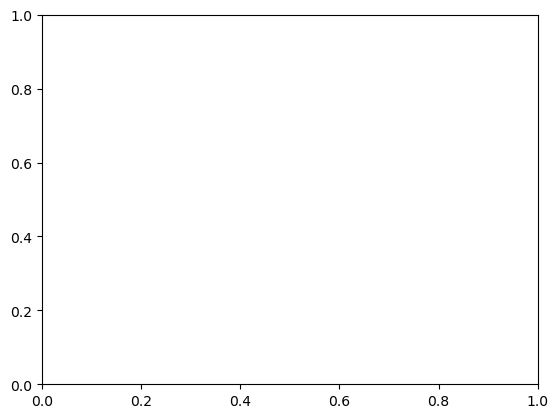

c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 30446 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 26631 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 30446 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 26631 missing from current font.
  font.set_text(s, 0, flags=flags)


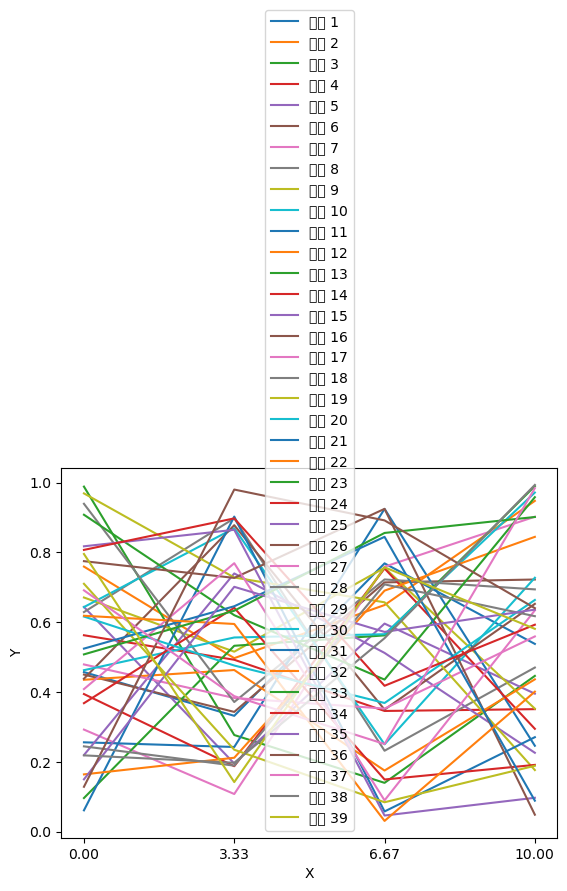

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 从CSV文件读取数据
data = pd.read_csv('车货相等原始数据.csv')

# 提取目标函数的指标数据
objectives = np.array([
    data.iloc[:, 0:4].values,
    data.iloc[:, 4:8].values,
    data.iloc[:, 8:12].values,
    data.iloc[:, 12:16].values
])

# 创建指标名称列表
indicators = ['Indicator e', 'Indicator k', 'Indicator p', 'Indicator d']

# 创建平行坐标图
fig, ax = plt.subplots()

# 生成示例数据
x = np.linspace(0, 10, 4)
objectives = np.random.rand(39, 4)

# 创建图形和坐标轴
fig, ax = plt.subplots()

# 遍历objectives并绘制它们
for i in range(len(objectives)):
    # 使用x值和对应的每个目标的y值
    ax.plot(x, objectives[i][:len(x)], label=f'目标 {i+1}')

# 设置x轴刻度
ax.set_xticks(x)

# 添加图例和标签
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')

# 显示图形
plt.show()

数据标准化处理

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('车货相等数据汇总.csv', header=None)

# 定义指标和函数
indicators = ['E', 'K', 'P', 'D']
functions = ['e', 'k', 'p', 'z'] 

# 提取指定的指标列
df_cols = df[indicators]

# 规范化  
for i, f in enumerate(functions):

    func_data = df_cols.iloc[:, 4*i:4*i+4]
    
    # 正向指标
    func_data.iloc[:, [0,2]] = func_data.iloc[:, [0,2]].apply(lambda x: (x - x.min()) / (x.max()-x.min()))
    
    # 反向指标 
    func_data.iloc[:, [1,3]] = func_data.iloc[:, [1,3]].apply(lambda x: 1 - (x - x.min()) / (x.max()-x.min()))

    # 赋值回原DataFrame
    df_cols.iloc[:, 4*i:4*i+4] = func_data

# 绘制雷达图
for i, f in enumerate(functions):

    values = df_cols.iloc[:, 4*i:4*i+4].mean().values
    angles = np.linspace(0, 2*np.pi, len(values), endpoint=False)

    plt.polar(angles, values, label=f)

plt.thetagrids(np.degrees(angles), labels=indicators)  
plt.fill(angles, values, alpha=0.25)
plt.legend(bbox_to_anchor=(1.2, 1))
plt.title('Radar Chart')
plt.show()

KeyError: "None of [Index(['E', 'K', 'P', 'D'], dtype='object')] are in the [columns]"

时间复杂度

c:\ProgramData\Anaconda3\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


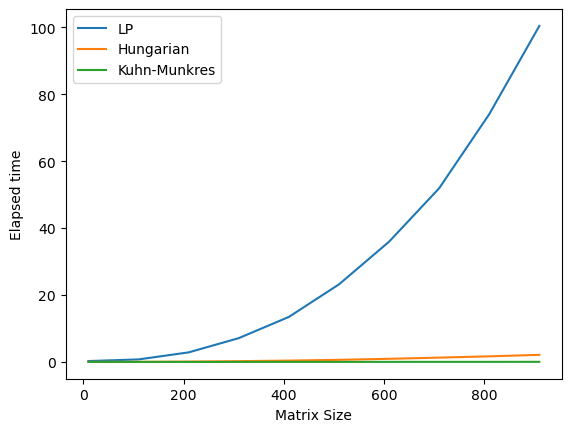

In [1]:
import time
import numpy as np
import csv
import networkx as nx
from scipy.optimize import linear_sum_assignment
from pulp import *
import matplotlib.pyplot as plt

import time as pytime  # 使用别名避免名称冲突

# 创建匹配矩阵
matrices = []
for n in range(10, 1010, 100):
    matrix = np.random.randint(0, 100, size=(n, n))
    matrices.append(matrix)

# 测试线性规划算法的时间复杂度
lp_times = []
for matrix in matrices:
    start_time = pytime.time()  # 使用别名

    prob = LpProblem("Matrix Selection", LpMaximize)
    x_vars = LpVariable.dicts("x", [(i, j) for i in range(matrix.shape[0]) for j in range(matrix.shape[1])], cat=LpBinary)
    for i in range(matrix.shape[0]):
        prob += lpSum([x_vars[(i, j)] for j in range(matrix.shape[1])]) == 1
    for j in range(matrix.shape[1]):
        prob += lpSum([x_vars[(i, j)] for i in range(matrix.shape[0])]) == 1
    prob += lpSum([x_vars[(i, j)] * matrix[i][j] for i in range(matrix.shape[0]) for j in range(matrix.shape[1])]), "Total Value"
    prob.solve()

    end_time = pytime.time()  # 使用别名
    lp_times.append(end_time - start_time)

# 测试匈牙利算法的时间复杂度
hungarian_times = []
for matrix in matrices:
    start_time = pytime.time()  # 使用别名

    G = nx.DiGraph()
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if matrix[i][j] != 0:
                G.add_edge(f"Vehicle {i}", f"Cargo {j}")
    matching = nx.bipartite.maximum_matching(G)

    end_time = pytime.time()  # 使用别名
    hungarian_times.append(end_time - start_time)

# 测试Kuhn-Munkres算法的时间复杂度
km_times = []
for matrix in matrices:
    start_time = pytime.time()  # 使用别名

    row_ind, col_ind = linear_sum_assignment(-matrix)
    matching = np.column_stack((row_ind, col_ind))

    end_time = pytime.time()  # 使用别名
    km_times.append(end_time - start_time)

# 将结果写入CSV文件
with open('algorithm_times.csv', mode='w') as file:
    writer = csv.writer(file)
    writer.writerow(['Matrix Size', 'LP', 'Hungarian', 'Kuhn-Munkres'])
    for i, matrix in enumerate(matrices):
        writer.writerow([matrix.shape[0], lp_times[i], hungarian_times[i], km_times[i]])

# 绘制折线图
x = np.array([matrix.shape[0] for matrix in matrices])
y1 = np.array(lp_times)
y2 = np.array(hungarian_times)
y3 = np.array(km_times)
plt.plot(x, y1, label='LP')
plt.plot(x, y2, label='Hungarian')
plt.plot(x, y3, label='Kuhn-Munkres')
plt.xlabel('Matrix Size')
plt.ylabel('Elapsed time')
plt.legend()
plt.show()

三种算法求解比较

In [2]:
import pandas as pd
import numpy as np
import math
from scipy.optimize import linprog
from scipy.optimize import linear_sum_assignment
from math import radians, sin, cos, sqrt, atan2
from pulp import *
import csv
import networkx as nx


# 读取货物和车辆的数据
cargo_df = pd.read_csv('cargo.csv')
vehicles_df = pd.read_csv('vehicles.csv')
type_matching_df = pd.read_csv('Type_matching.csv')


def haversine_distance(point1, point2):
    lat1, lon1 = point1
    lat2, lon2 = point2
    R = 6371  # 地球半径，单位km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2) ** 2
    c0 = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c0
    return distance

# 定义模型参数
w1, w2, w3, w4 = 0.11, 0.33, 0.23, 0.33
n_vehicles = len(vehicles_df)
n_cargo = len(cargo_df)
cargo_types = cargo_df['type'].values
cargo_weights = cargo_df['w_j^c'].values
cargo_volumes = cargo_df['v_j^c'].values
cargo_origins = list(zip(cargo_df['lat_j^c1'].values, cargo_df['lon_j^c1'].values))
cargo_destinations = list(zip(cargo_df['lat_j^c2'].values, cargo_df['lon_j^c2'].values))
cargo_pickup_times = pd.to_datetime(cargo_df['t_j^c1'], format='%Y%m%d%H').values
cargo_delivery_times = pd.to_datetime(cargo_df['t_j^c2'], format='%Y%m%d%H').values
cargo_fees = cargo_df['f_j^c'].values
vehicle_types = vehicles_df['type'].values
vehicle_weights = vehicles_df['w_i^v'].values
vehicle_volumes = vehicles_df['v_i^v'].values
vehicle_latitudes = vehicles_df['lat_i^v'].values
vehicle_longitudes = vehicles_df['lon_i^v'].values
cargo_indexes = np.arange(n_cargo)
vehicle_indexes = np.arange(n_vehicles)

# 计算车辆和货物之间的匹配度a1
matched_pairs = set() # 创建一个空的集合
type_matching = type_matching_df.pivot(index='type_i^v', columns='type_j^c', values='num').fillna(0)
a1 = np.zeros((n_vehicles, n_cargo))
for i in range(n_vehicles):
    for j in range(n_cargo):
        if (i,j) in matched_pairs:
            break # 如果该组匹配已经出现过，则直接跳出内层for循环
        else:
            matching_type = type_matching.loc[vehicles_df['type'][i].split('_')[0], cargo_df['type'][j]]
            matched_pairs.add((i,j)) # 将该组匹配加入已匹配组合的集合中
            a1[i, j] = matching_type
            if matching_type == 0:
                a1[i, j] = 0
                break  # 直接跳出内层for循环

# 计算车辆和货物之间的匹配度a2
a2 = np.zeros((n_vehicles, n_cargo))
for i in range(n_vehicles):
    for j in range(n_cargo):
            # 检查重量和体积是否符合要求
            if cargo_weights[j] <= vehicle_weights[i] and cargo_volumes[j] <= vehicle_volumes[i]:
                a2[i, j] = round(max(1 - ((vehicle_weights[i] - cargo_weights[j]) / vehicle_weights[i]), 1 - ((vehicle_volumes[i] - cargo_volumes[j]) / vehicle_volumes[i])), 2)
                matched_pairs.add((i, j))
            else:
                a2[i, j] = 0

# 计算车辆和货物之间的匹配度a3、a4
a3 = np.zeros((n_vehicles, n_cargo))
a4 = np.zeros((n_vehicles,n_cargo))
z = np.zeros((n_vehicles, n_cargo))
e = np.zeros((n_vehicles,n_cargo))
c = np.zeros((n_vehicles,n_cargo))
dist1 = np.zeros((n_vehicles,n_cargo))
dist2 = np.zeros((n_vehicles,n_cargo))
time1 = np.zeros((n_vehicles,n_cargo))
time2 = np.zeros((n_vehicles,n_cargo))
total_time = np.zeros((n_vehicles,n_cargo))
delta = np.timedelta64(1, 's')
for i in range(n_vehicles):
    for j in range(n_cargo):
            # 计算距离和时间
            dist1[i, j] = haversine_distance((vehicle_latitudes[i], vehicle_longitudes[i]), cargo_origins[j])
            dist2[i, j] = haversine_distance(cargo_origins[j], cargo_destinations[j])
            time1[i, j] = dist1[i, j] / 40
            time2[i, j] = dist2[i, j] / 80
            total_time[i, j] = time1[i, j] + time2[i, j] + 3
            # 检查时间是否符合要求
         
            time_diff_seconds = (cargo_delivery_times[j] - cargo_pickup_times[j]) / delta
            if total_time[i, j] <= time_diff_seconds / 3600:
                a3[i, j] = round(total_time[i, j] / (time_diff_seconds / (3600 * 2)), 2)
                a4[i, j] = round(dist2[i, j] / (dist1[i, j] + dist2[i, j]), 2)
                matched_pairs.add((i, j))
            else:
                a3[i, j] = 0
                break

b = 1.92
u = 0.5
c[i, j] = u * dist1[i, j] + b * (cargo_weights[j] / vehicle_weights[i]) * u * dist2[i, j]

# 循环检查每个匹配对
for i in range(n_vehicles):
    for j in range(n_cargo):
        # 检查个匹配度是否为零
        if np.any([a1[i, j] == 0, a2[i, j] == 0, a3[i, j] == 0]):
            e[i, j] = z[i, j] = 0
        else:
            a4[i, j] = round(dist2[i, j] / (dist1[i, j] + dist2[i, j]), 2)
            z[i, j] = round((w1 * a1[i, j] + w2 * a2[i, j] + w3 * a3[i, j] + w4 * a4[i, j]), 2)
            e[i, j] = round((cargo_fees[j] - c[i, j]) / (total_time[i, j] + 3), 2)

z[i, j] = w1 * a1[i, j] + w2 * a2[i, j] + w3 * a3[i, j] + w4 * a4[i, j]
# 输出z矩阵
print("z矩阵:")
print(z)


# 将z矩阵保存在z_matrix全局变量中
z_matrix = z


# 定义some_function函数
def some_function():
    global z_matrix
    # 在函数内部对z_matrix做一些处理或者调用其他函数
    # ...

# 在后续代码中调用some_function函数
some_function()


matching_matrix = z_matrix

# 使用线性规划求解车辆和货物匹配问题
# 定义矩阵选择问题
prob = LpProblem("Matrix Selection", LpMaximize)

# 创建40 * 40个变量，表示每个矩阵元素的选择情况
x_vars = LpVariable.dicts("x", [(i, j) for i in range(40) for j in range(40)], cat=LpBinary)

# 每行每列只能选择一个元素的约束条件
for i in range(40):
    prob += lpSum([x_vars[(i, j)] for j in range(40)]) == 1
for j in range(40):
    prob += lpSum([x_vars[(i, j)] for i in range(40)]) == 1

# 目标函数：所有选择的元素的和
prob += lpSum([x_vars[(i, j)] * matching_matrix[i][j] for i in range(40) for j in range(40)]), "Total Value"

# 求解线性规划问题
prob.solve()

# 输出车辆和货物匹配的结果到csv文件
e_sum = 0
k_sum = 0
count = 0

with open('lp_vcm_matches.csv', mode='w', encoding='utf-8-sig', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Vehicle', 'Cargo', 'Match', 'E', 'K'])
    
    for i in range(40):
        for j in range(40):
            if value(x_vars[(i, j)]) == 1:
                if matching_matrix[i][j] != 0:
                    match = 'Yes'
                    print(f"车辆{i}和货物{j}匹配")
                else:
                    match = 'No'
                    print(f"车辆{i}和货物{j}不匹配")
                writer.writerow([i, j, match, e[i, j], 1 - a4[i, j]])
                
                # 累加"E"和"K"的值
                e_sum += e[i, j]
                k_sum += 1 - a4[i, j]
                count += 1
    
    # 计算"E"和"K"的平均值
    e_mean = e_sum / count
               

# 使用匈牙利算法求解车辆和货物匹配问题
G = nx.DiGraph()
for i in range(n_vehicles):
    for j in range(n_cargo):
        if matching_matrix[i][j] != 0:
            G.add_edge(f"Vehicle {i}", f"Cargo {j}")
matching = nx.bipartite.maximum_matching(G)

# 输出车辆和货物匹配的结果到csv文件
# 计算"E"和"K"列的平均值
e_sum = 0
k_sum = 0
count = 0

with open('hungarian_vcm_matches.csv', mode='w', encoding='utf-8-sig', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Vehicle', 'Cargo', 'Match', 'E', 'K'])
    
    for vehicle, cargo in matching.items():
        if 'Vehicle' in vehicle:
            vehicle_index = int(vehicle.split()[1])
            cargo_index = int(cargo.split()[1])
            a = matching_matrix[vehicle_index][cargo_index]
            writer.writerow([vehicle_index, cargo_index, 'Yes', e[vehicle_index][cargo_index], 1 - a4[vehicle_index][cargo_index]])
            
            # 累加"E"和"K"的值
            e_sum += e[vehicle_index][cargo_index]
            k_sum += 1 - a4[vehicle_index][cargo_index]
            count += 1
    
    # 计算"E"和"K"的平均值
    e_mean = e_sum / count
    k_mean = k_sum / count
    
    # 写入"E"和"K"的平均值到CSV文件的对应列的最下方
    writer.writerow(['Average', 'Average', '', e_mean, k_mean])

# 使用Kuhn-Munkres算法求解车辆和货物匹配问题
row_ind, col_ind = linear_sum_assignment(-matching_matrix)
matching = np.column_stack((row_ind, col_ind))

# 输出车辆和货物匹配的结果到csv文件
e_sum = 0
k_sum = 0
count = 0

with open('kuhn_munkres_vcm_matches.csv', mode='w', encoding='utf-8-sig', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Vehicle', 'Cargo', 'Match', 'E', 'K'])
    
    for vehicle, cargo in matching:
        writer.writerow([vehicle, cargo, 'Yes', e[vehicle][cargo], 1 - a4[vehicle][cargo]])
        
        # 累加"E"和"K"的值
        e_sum += e[vehicle][cargo]
        k_sum += 1 - a4[vehicle][cargo]
        count += 1
    
    # 计算"E"和"K"的平均值
    e_mean = e_sum / count
    k_mean = k_sum / count
    
    # 写入"E"和"K"的平均值到CSV文件的对应列的最下方
    writer.writerow(['Average', 'Average', '', e_mean, k_mean]) 

z矩阵:
[[0.44   0.54   0.44   ... 0.72   0.     0.66  ]
 [0.46   0.53   0.49   ... 0.71   0.43   0.51  ]
 [0.49   0.5    0.47   ... 0.63   0.58   0.57  ]
 ...
 [0.53   0.6    0.5    ... 0.73   0.     0.66  ]
 [0.41   0.43   0.37   ... 0.57   0.46   0.57  ]
 [0.48   0.52   0.45   ... 0.71   0.5    0.5511]]


c:\ProgramData\Anaconda3\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


车辆0和货物33匹配
车辆1和货物5匹配
车辆2和货物25匹配
车辆3和货物31匹配
车辆4和货物34匹配
车辆5和货物26匹配
车辆6和货物35匹配
车辆7和货物17匹配
车辆8和货物15匹配
车辆9和货物12匹配
车辆10和货物4匹配
车辆11和货物37匹配
车辆12和货物8匹配
车辆13和货物2匹配
车辆14和货物29匹配
车辆15和货物0匹配
车辆16和货物22匹配
车辆17和货物27匹配
车辆18和货物11匹配
车辆19和货物23匹配
车辆20和货物7匹配
车辆21和货物28匹配
车辆22和货物6匹配
车辆23和货物30匹配
车辆24和货物21匹配
车辆25和货物14匹配
车辆26和货物19匹配
车辆27和货物20匹配
车辆28和货物18匹配
车辆29和货物24匹配
车辆30和货物39匹配
车辆31和货物1匹配
车辆32和货物9匹配
车辆33和货物32匹配
车辆34和货物38匹配
车辆35和货物16匹配
车辆36和货物36匹配
车辆37和货物10匹配
车辆38和货物13匹配
车辆39和货物3匹配


绘制箱线图